In [1]:
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision import datasets
from collections import Counter

from classic_vit import ViT
from her2_dataset import HER2Dataset
from patch_embedding import PatchEmbedding

transform = ToTensor()

torch.manual_seed(0)

IMAGE_WIDTH = 299
IMAGE_HEIGHT = 299
IMAGE_CHANNELS = 3
N_PATCHES = 13

MAX_CHECKPOINTS = 3

assert IMAGE_WIDTH%N_PATCHES==0

PATCH_WIDTH = IMAGE_WIDTH//N_PATCHES
PATCH_HEIGHT = IMAGE_HEIGHT//N_PATCHES


DATASET_PATH='../datasets/HER2_gastric_5classes'
# 20% of data goes to test
TEST_SPLIT = 0.2
BATCH_SIZE = 16

N_EPOCHS = 20
LR = 0.0001


/home/newt/miniconda3/envs/ds/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

dataset = HER2Dataset(DATASET_PATH, transform=ToTensor())
train_dataset, test_dataset = dataset.genSplits(TEST_SPLIT)
train_loader, test_loader = dataset.getDataLoaders(BATCH_SIZE)

print(f"Dataset split:\nTrain: {len(train_dataset)}\nTest: {len(test_dataset)}")



Dataset split:
Train: 1627
Test: 406


Text(0.5, 1.0, 'Test Split')

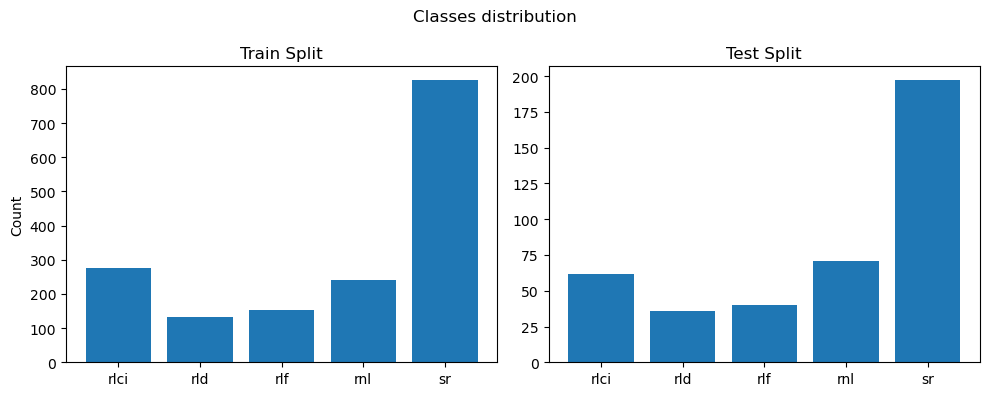

In [3]:
train_count, test_count = dataset.getSampleCountByClass()

fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.suptitle("Classes distribution")
ax[0].set_ylabel("Count")
ax[0].bar(list(zip(*train_count))[0], list(zip(*train_count))[1], tick_label=list(zip(*train_count))[2])
ax[0].set_title("Train Split")
ax[1].bar(list(zip(*test_count))[0], list(zip(*test_count))[1], tick_label=list(zip(*test_count))[2])
ax[1].set_title("Test Split")

torch.Size([16, 3, 299, 299])
torch.Size([16, 3, 299, 299])


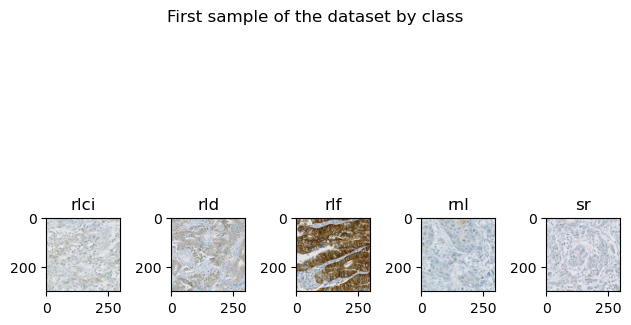

In [4]:

data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape)
class_first_sample = list(map(lambda x: np.where(x == np.array(labels))[0][0], dataset.class_to_idx.values()))


print(images.shape)

fig, axes = plt.subplots(tight_layout=True, ncols=len(class_first_sample))
fig.suptitle("First sample of the dataset by class")

for ii in range(len(class_first_sample)):
    ax = axes[ii]
#     helper.imshow(images[ii], ax=ax, normalize=False)
    ax.set_title(dataset.classes[labels[class_first_sample[ii]]])
    ax.imshow(torch.transpose(images[class_first_sample[ii]], 0, 2))

/home/newt/miniconda3/envs/ds/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


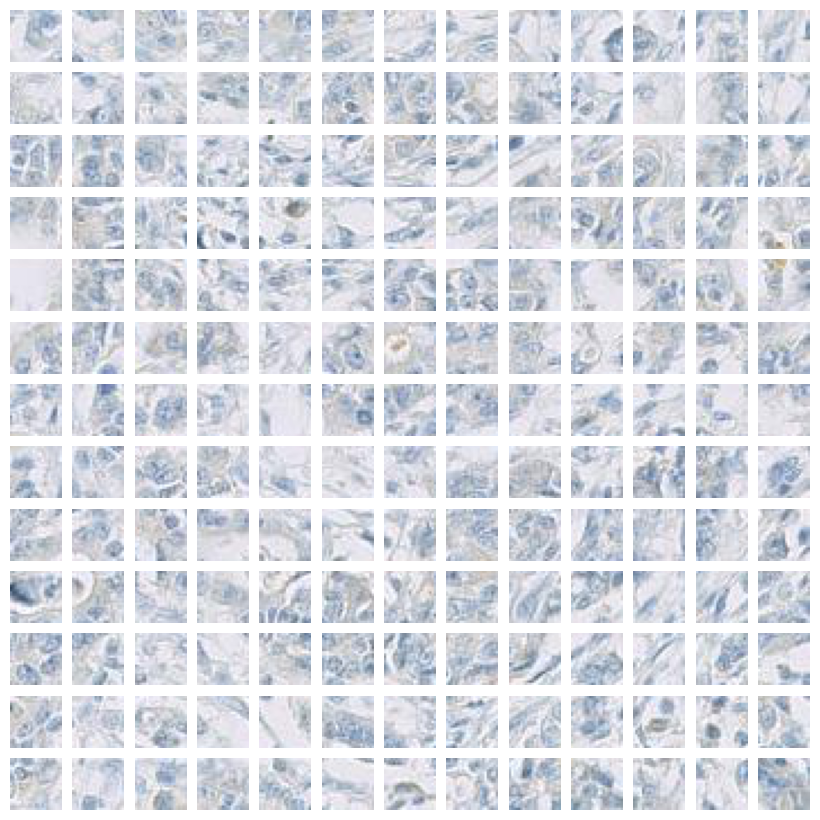

In [5]:
from patch_embedding import ImagePatcher


patcher = ImagePatcher(in_channels=IMAGE_CHANNELS, patch_size=IMAGE_WIDTH//N_PATCHES, img_size=IMAGE_HEIGHT)
gridSpec = dict(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)
data_iter = iter(train_loader)
images, labels = next(data_iter)
patches = patcher.toPatchesTensor(images[1].unsqueeze(0))
#patches = patches.reshape((1, N_PATCHES,N_PATCHES,23,23,3))
fig, axes = plt.subplots(N_PATCHES, N_PATCHES ,tight_layout=True, figsize=(8,8), sharex=True, sharey=True, gridspec_kw=gridSpec)
for i in range((N_PATCHES)):
    for j in range((N_PATCHES)):
        axes[i,j].axis('off')
        axes[i,j].set_aspect('equal')
        axes[i,j].imshow(patches[0, i, j], interpolation=None)

# axes.vlines(range(0,IMAGE_WIDTH,PATCH_WIDTH), 0, IMAGE_HEIGHT)
# axes.hlines(range(0,IMAGE_HEIGHT,PATCH_HEIGHT), 0, IMAGE_WIDTH)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

print(f"ROI divided into regions of {IMAGE_WIDTH}x{IMAGE_HEIGHT}x{IMAGE_CHANNELS}\nUsing {N_PATCHES}x{N_PATCHES} patches of {PATCH_WIDTH}x{PATCH_HEIGHT}x{IMAGE_CHANNELS}")
# model = ViT(
#         in_channels= IMAGE_CHANNELS, 
#         img_size=IMAGE_WIDTH,
#         patch_size=IMAGE_WIDTH//N_PATCHES, 
#         emb_size=1024,
#         num_heads=16,
#         depth=6,
#         n_classes=len(dataset.classes), 
#         dropout=0.1,
#         forward_expansion=2,
#         ).to(device)


from vit_pytorch import ViT
import timm

m = timm.create_model('inception_v3', pretrained=True, num_classes=0, global_pool='')
# for param in m.parameters():
#     param.requires_grad = False

outputsize = 2048*8*8

#patches_embedded = ViT(patch_size=23, img_size=299, feature_extractor=m, fe_size=outputsize, num_heads=6)(x)
#print(patches_embedded.shape)
from classic_vit_withFE_MHA import ViTWithFE
model = ViTWithFE(
    in_channels= IMAGE_CHANNELS, 
    img_size=IMAGE_WIDTH,
    patch_size=IMAGE_WIDTH//N_PATCHES, 
    # emb_size=768,
    num_heads=6,
    depth=6,
    n_classes=len(dataset.classes), 
    dropout=0.1,
    forward_expansion=2,
    fe_size=outputsize,
    feature_extractor=m
).to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.2f}MB'.format(size_all_mb))


Using device:  cuda (NVIDIA GeForce RTX 3080)
ROI divided into regions of 299x299x3
Using 13x13 patches of 23x23x3
51511781
model size: 196.63MB


In [6]:
# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss}")

# Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20 loss: 1.2787699243601636


Training:   5%|▌         | 1/20 [00:21<06:53, 21.78s/it]

Test loss: 0.9773485706402707
Test accuracy: 62.32%


Epoch 2/20 loss: 0.8787627079907586


Training:  10%|█         | 2/20 [00:42<06:16, 20.91s/it]

Test loss: 0.8711247914112532
Test accuracy: 64.29%


Epoch 3/20 loss: 0.727120106711107


Training:  15%|█▌        | 3/20 [01:02<05:50, 20.60s/it]

Test loss: 0.9704132274939461
Test accuracy: 63.30%


Epoch 4/20 loss: 0.5881415241781403


Training:  20%|██        | 4/20 [01:22<05:26, 20.41s/it]

Test loss: 0.8743292861259901
Test accuracy: 66.75%


Epoch 5/20 loss: 0.5077971887646939


Training:  25%|██▌       | 5/20 [01:42<05:03, 20.21s/it]

Test loss: 0.8880308132905227
Test accuracy: 69.70%


Epoch 6/20 loss: 0.45748550138052785


Training:  30%|███       | 6/20 [02:02<04:42, 20.19s/it]

Test loss: 0.8364548350755985
Test accuracy: 70.20%


Epoch 7/20 loss: 0.47481972797244204


Training:  35%|███▌      | 7/20 [02:22<04:22, 20.16s/it]

Test loss: 0.985481627858602
Test accuracy: 66.26%


Epoch 8/20 loss: 0.4318706586080437


Training:  40%|████      | 8/20 [02:43<04:03, 20.28s/it]

Test loss: 1.0111252058010836
Test accuracy: 67.49%


Epoch 9/20 loss: 0.36615457086294306


Training:  45%|████▌     | 9/20 [03:03<03:42, 20.26s/it]

Test loss: 1.1595056458161428
Test accuracy: 66.50%


Epoch 10/20 loss: 0.29768286612542233


Training:  50%|█████     | 10/20 [03:23<03:22, 20.25s/it]

Test loss: 1.149906319494431
Test accuracy: 69.95%


Epoch 11/20 loss: 0.31442888358644405


Training:  55%|█████▌    | 11/20 [03:43<03:02, 20.28s/it]

Test loss: 0.9102389213557427
Test accuracy: 73.89%


Epoch 12/20 loss: 0.4042879171377304


Training:  60%|██████    | 12/20 [04:04<02:42, 20.27s/it]

Test loss: 0.9528900912174812
Test accuracy: 70.44%


Epoch 13/20 loss: 0.3133494627534176


Training:  65%|██████▌   | 13/20 [04:24<02:21, 20.17s/it]

Test loss: 0.9429528862237931
Test accuracy: 71.18%


Epoch 14/20 loss: 0.2180250202141264


Training:  70%|███████   | 14/20 [04:44<02:00, 20.17s/it]

Test loss: 1.1417075647757604
Test accuracy: 70.94%


Epoch 15/20 loss: 0.21050552603806932


Training:  75%|███████▌  | 15/20 [05:04<01:40, 20.15s/it]

Test loss: 1.041482675748949
Test accuracy: 73.40%


Epoch 16/20 loss: 0.3040354057196894


Training:  80%|████████  | 16/20 [05:24<01:20, 20.15s/it]

Test loss: 1.1812979418497818
Test accuracy: 68.97%


Epoch 17/20 loss: 0.3053003201516819


Training:  85%|████████▌ | 17/20 [05:44<01:00, 20.17s/it]

Test loss: 1.0612475539629274
Test accuracy: 72.66%


Epoch 18/20 loss: 0.43580099458203586


Training:  90%|█████████ | 18/20 [06:04<00:40, 20.15s/it]

Test loss: 0.9137961658147664
Test accuracy: 73.89%


Epoch 19/20 loss: 0.40002130139984354


Training:  95%|█████████▌| 19/20 [06:24<00:20, 20.16s/it]

Test loss: 0.924732921215204
Test accuracy: 71.67%


Epoch 20/20 loss: 0.4853542206407178


Training: 100%|██████████| 20/20 [06:44<00:00, 20.24s/it]

Test loss: 0.9423845318647529
Test accuracy: 67.73%


In [8]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
    output = model(inputs.to(device)) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth


In [9]:
from sklearn.metrics import classification_report
print(dataset.classes)
print(classification_report(y_pred=y_pred, y_true=y_true))

['rlci', 'rld', 'rlf', 'rnl', 'sr']
              precision    recall  f1-score   support

           0       0.33      0.03      0.06        62
           1       0.56      0.69      0.62        36
           2       0.82      0.93      0.87        40
           3       0.53      0.14      0.22        71
           4       0.66      0.97      0.78       197

    accuracy                           0.65       406
   macro avg       0.58      0.55      0.51       406
weighted avg       0.59      0.65      0.57       406

